<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-07-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,totalTestResults
37,NY,330407,791136,1121543
34,NJ,135454,163305,298759
21,MA,75333,290690,366023
16,IL,73760,325954,399714
5,CA,62512,812760,875272
41,PA,54238,216321,270559
24,MI,46326,213927,260253
10,FL,39199,474142,513341
47,TX,36609,440509,477118
7,CT,32411,88130,120541


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='GA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
94,2020-04-25,933310,5197717,48069,35991.0,1818.0,0.731482
95,2020-04-26,960343,5404137,49164,27033.0,1095.0,0.752669
96,2020-04-27,981134,5593495,50354,20791.0,1190.0,0.768964
97,2020-04-28,1006137,5796273,52482,25003.0,2128.0,0.788561
98,2020-04-29,1033157,6026170,55182,27020.0,2700.0,0.809737
99,2020-04-30,1062503,6255769,57320,29346.0,2138.0,0.832737
100,2020-05-01,1095681,6552602,59059,33178.0,1739.0,0.858741
101,2020-05-02,1125719,6805241,60710,30038.0,1651.0,0.882283
102,2020-05-03,1152006,7053366,61868,26287.0,1158.0,0.902885
103,2020-05-04,1173453,7285374,62780,21447.0,912.0,0.919695


In [74]:
dfCAPos[-5:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
61,2020-05-04,29368,183325,1222,766.0,45.0,0.914720
62,2020-05-05,29711,200883,1288,343.0,66.0,0.925403
63,2020-05-06,30696,204137,1311,985.0,23.0,0.956083
64,2020-05-07,31439,217303,1336,743.0,25.0,0.979225
65,2020-05-08,32106,227567,1377,667.0,41.0,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-04,1173453,6111921,2791,50062.0,127397.0,9366.0,4579.0,4848.0,430.0,187180.0,62780,127397.0,7288165,7285374,7285374,912.0,1601.0,210561.0,21447.0,232008.0
2020-05-05,1195605,6348723,2633,50906.0,129357.0,9348.0,4794.0,4818.0,439.0,189791.0,65307,129357.0,7546961,7544328,7544328,2527.0,1960.0,236802.0,22152.0,258954.0
2020-05-06,1220557,6566236,2742,50227.0,131477.0,9380.0,4911.0,4753.0,449.0,189910.0,67256,131477.0,7789535,7786793,7786793,1949.0,2120.0,226826.0,24952.0,242465.0
2020-05-07,1248137,6857376,3171,49130.0,135176.0,12137.0,5174.0,7070.0,529.0,195036.0,70002,135176.0,8108684,8105513,8105513,2746.0,3699.0,291140.0,27580.0,318720.0
2020-05-08,1275916,7132872,3307,47718.0,142037.0,11780.0,6294.0,6788.0,531.0,198993.0,71762,142037.0,8412095,8408788,8408788,1760.0,6861.0,275496.0,27779.0,303275.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325,183325,45.0,133.0,7463.0,766.0,8229.0
2020-05-05,29711,171172,0,0.0,5634.0,0.0,1318.0,0.0,0.0,0.0,1288,5634.0,200883,200883,200883,66.0,108.0,17215.0,343.0,17558.0
2020-05-06,30696,173441,0,0.0,5765.0,0.0,1343.0,0.0,0.0,0.0,1311,5765.0,204137,204137,204137,23.0,131.0,2269.0,985.0,3254.0
2020-05-07,31439,185864,0,0.0,5835.0,0.0,1374.0,0.0,0.0,0.0,1336,5835.0,217303,217303,217303,25.0,70.0,12423.0,743.0,13166.0
2020-05-08,32106,195461,0,0.0,5935.0,0.0,1399.0,0.0,0.0,0.0,1377,5935.0,227567,227567,227567,41.0,100.0,9597.0,667.0,10264.0


In [12]:
rn = gbCA.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

16.193363844393595

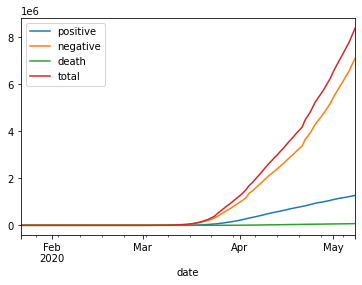

In [13]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [14]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-25,860772,44053
2020-04-26,899281,46204
2020-04-27,931698,47980
2020-04-28,960916,49170
2020-04-29,983457,50492
2020-04-30,1003974,52428
2020-05-01,1035353,55337
2020-05-02,1067127,57406
2020-05-03,1093880,62406


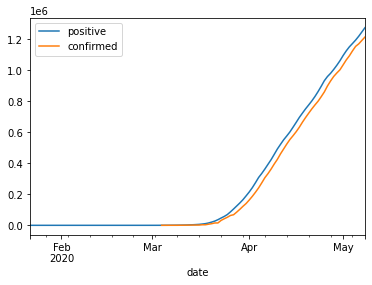

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [16]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-02,28306,146494,0,0.0,5387.0,0.0,1247.0,0.0,0.0,0.0,1174,5387.0,174800,174800,174800,20.0,118.0,5397.0,1036.0,6433.0
2020-05-03,28602,146494,0,0.0,5393.0,0.0,1249.0,0.0,0.0,0.0,1177,5393.0,175096,175096,175096,3.0,6.0,0.0,296.0,296.0
2020-05-04,29368,153957,0,0.0,5526.0,0.0,1284.0,0.0,0.0,0.0,1222,5526.0,183325,183325,183325,45.0,133.0,7463.0,766.0,8229.0
2020-05-05,29711,171172,0,0.0,5634.0,0.0,1318.0,0.0,0.0,0.0,1288,5634.0,200883,200883,200883,66.0,108.0,17215.0,343.0,17558.0
2020-05-06,30696,173441,0,0.0,5765.0,0.0,1343.0,0.0,0.0,0.0,1311,5765.0,204137,204137,204137,23.0,131.0,2269.0,985.0,3254.0
2020-05-07,31439,185864,0,0.0,5835.0,0.0,1374.0,0.0,0.0,0.0,1336,5835.0,217303,217303,217303,25.0,70.0,12423.0,743.0,13166.0
2020-05-08,32106,195461,0,0.0,5935.0,0.0,1399.0,0.0,0.0,0.0,1377,5935.0,227567,227567,227567,41.0,100.0,9597.0,667.0,10264.0


In [17]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1257023
dead           75662
dtype: int64

In [18]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    62148
dead          2535
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1257023
Spain              221447
Italy              215858
United Kingdom     207977
Russia             177160
France             174918
Germany            169430
Brazil             135773
Turkey             133721
Iran               103135
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-05-08,39199,1738,39199,1.000000
FL,2020-05-07,38828,1667,39199,0.990535
FL,2020-05-06,38002,1605,39199,0.969464
FL,2020-05-05,37439,1536,39199,0.955101
FL,2020-05-04,36897,1423,39199,0.941274
FL,2020-05-03,36078,1403,39199,0.920381
FL,2020-05-02,35463,1388,39199,0.904691


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

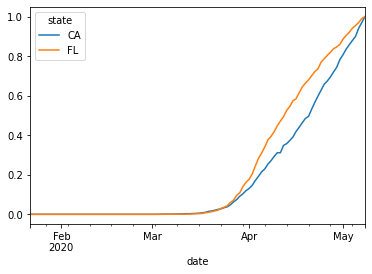

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

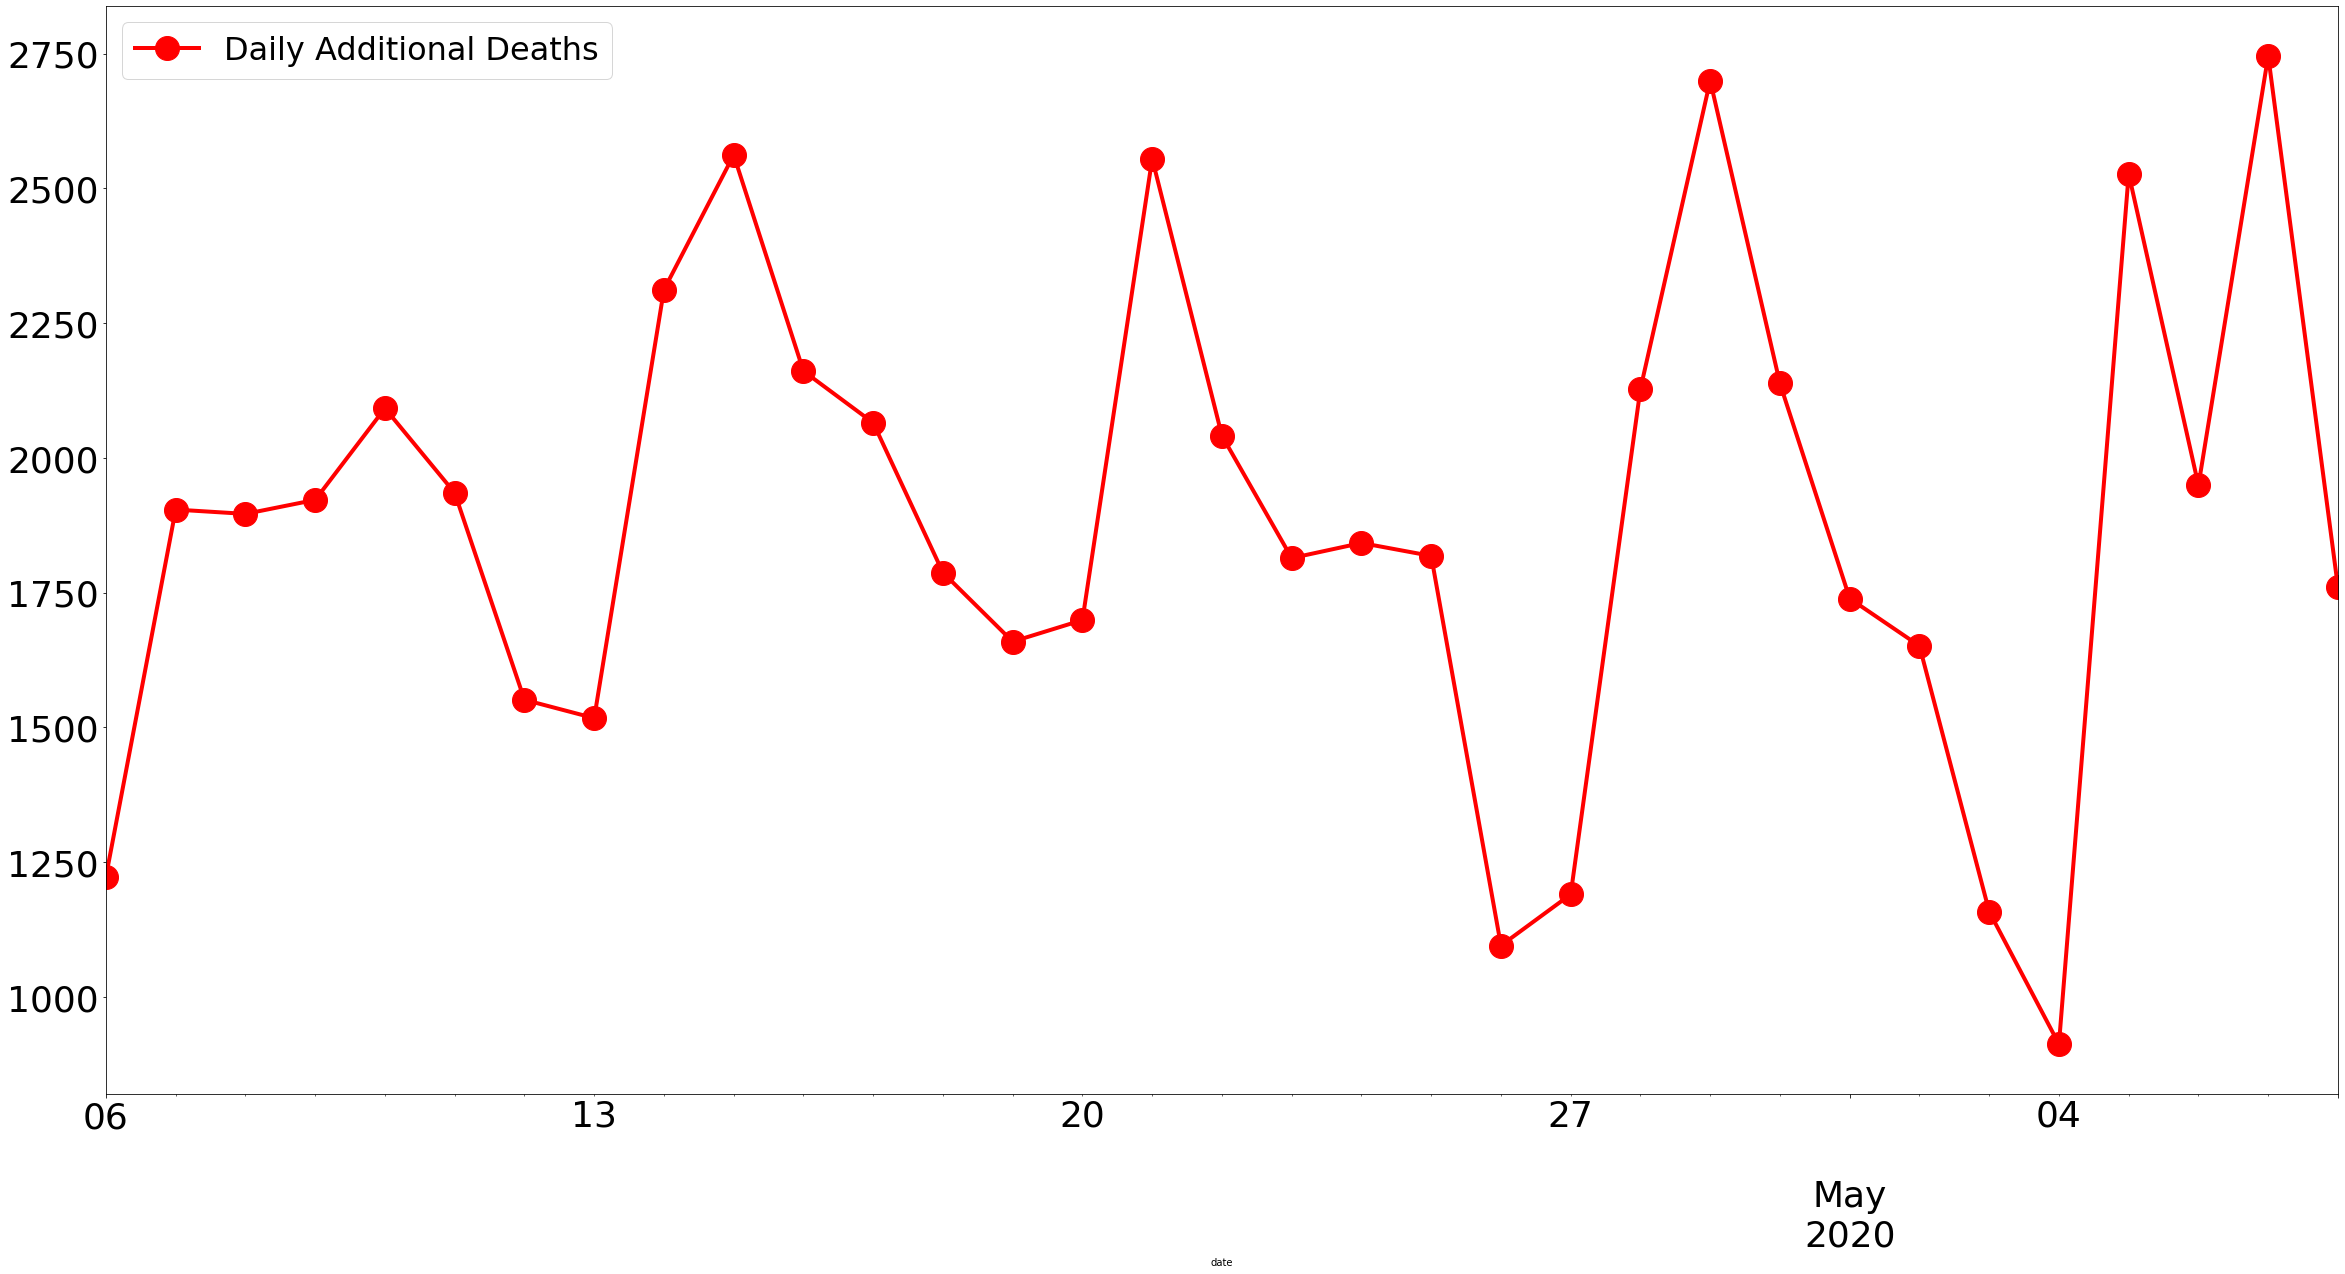

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


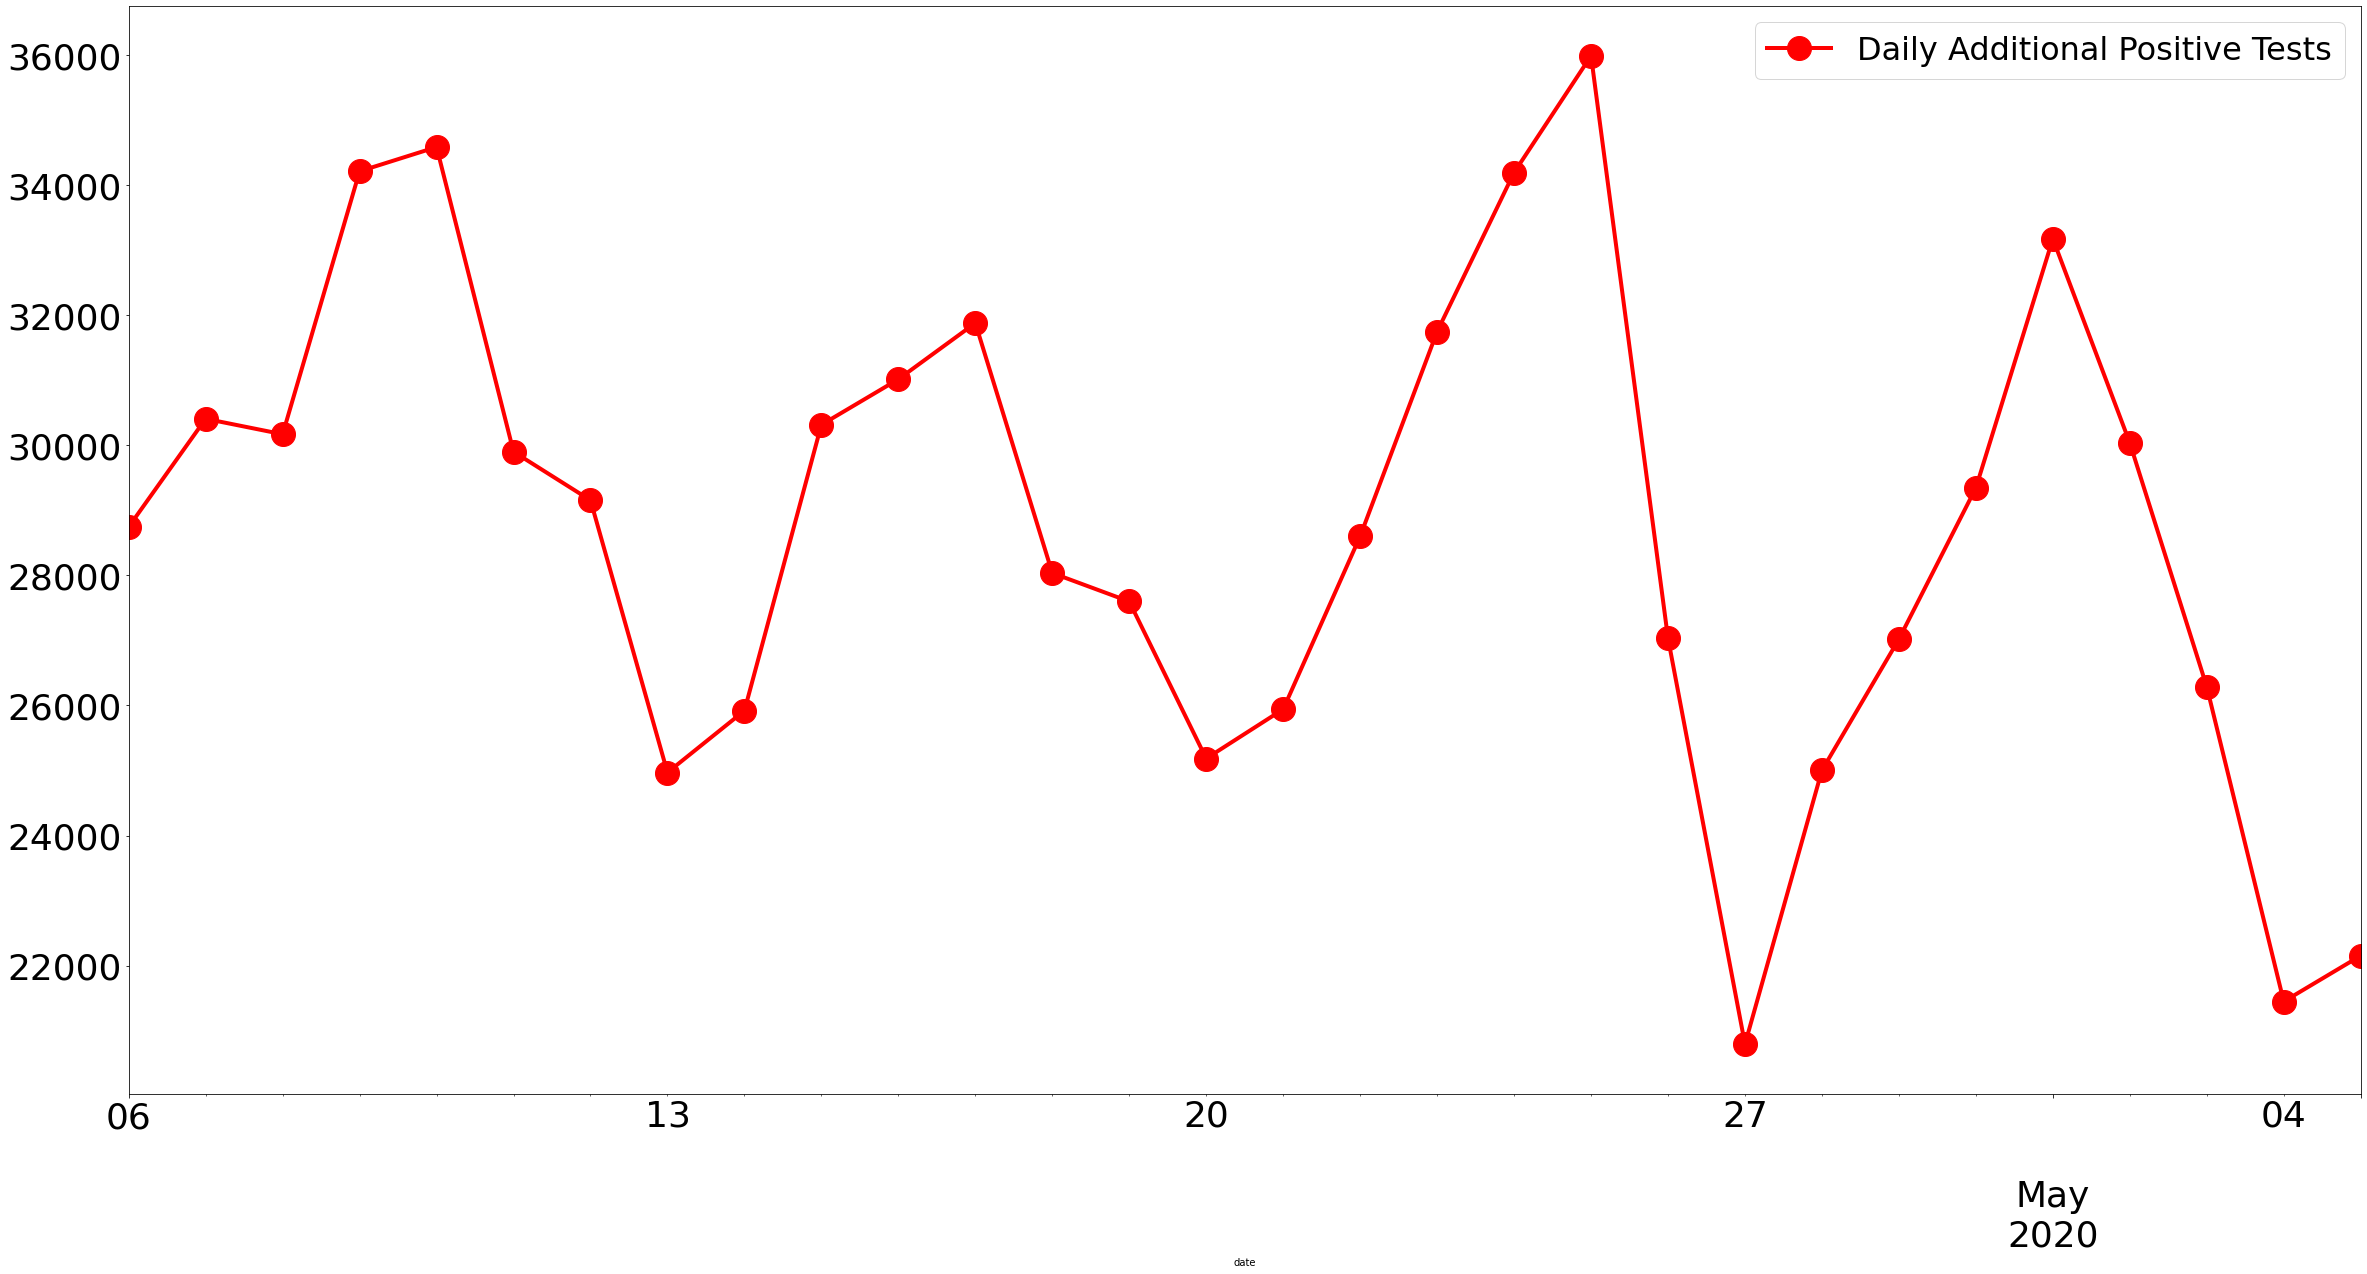

In [30]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:-3].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


In [33]:
dfDoW.sum().deathIncrease



0     7186.0
1    12474.0
2    12357.0
3    12216.0
4    11135.0
5     9063.0
6     7331.0
Name: deathIncrease, dtype: float64

In [34]:
dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]


,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,
2020-05-08,0.0,0.0,1129.0,3.0,1132.0
2020-05-08,26.0,29.0,4618.0,323.0,4941.0
2020-05-08,1.0,4.0,3916.0,83.0,3999.0
2020-05-08,0.0,0.0,0.0,0.0,0.0
2020-05-08,67.0,33.0,8240.0,581.0,8821.0
...,...,...,...,...,...
2020-01-26,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0


In [35]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4113.0,34316.0
202012,360.0,2498.0,179297.0,31483.0,210780.0
202013,2090.0,13766.0,497952.0,107963.0,605915.0


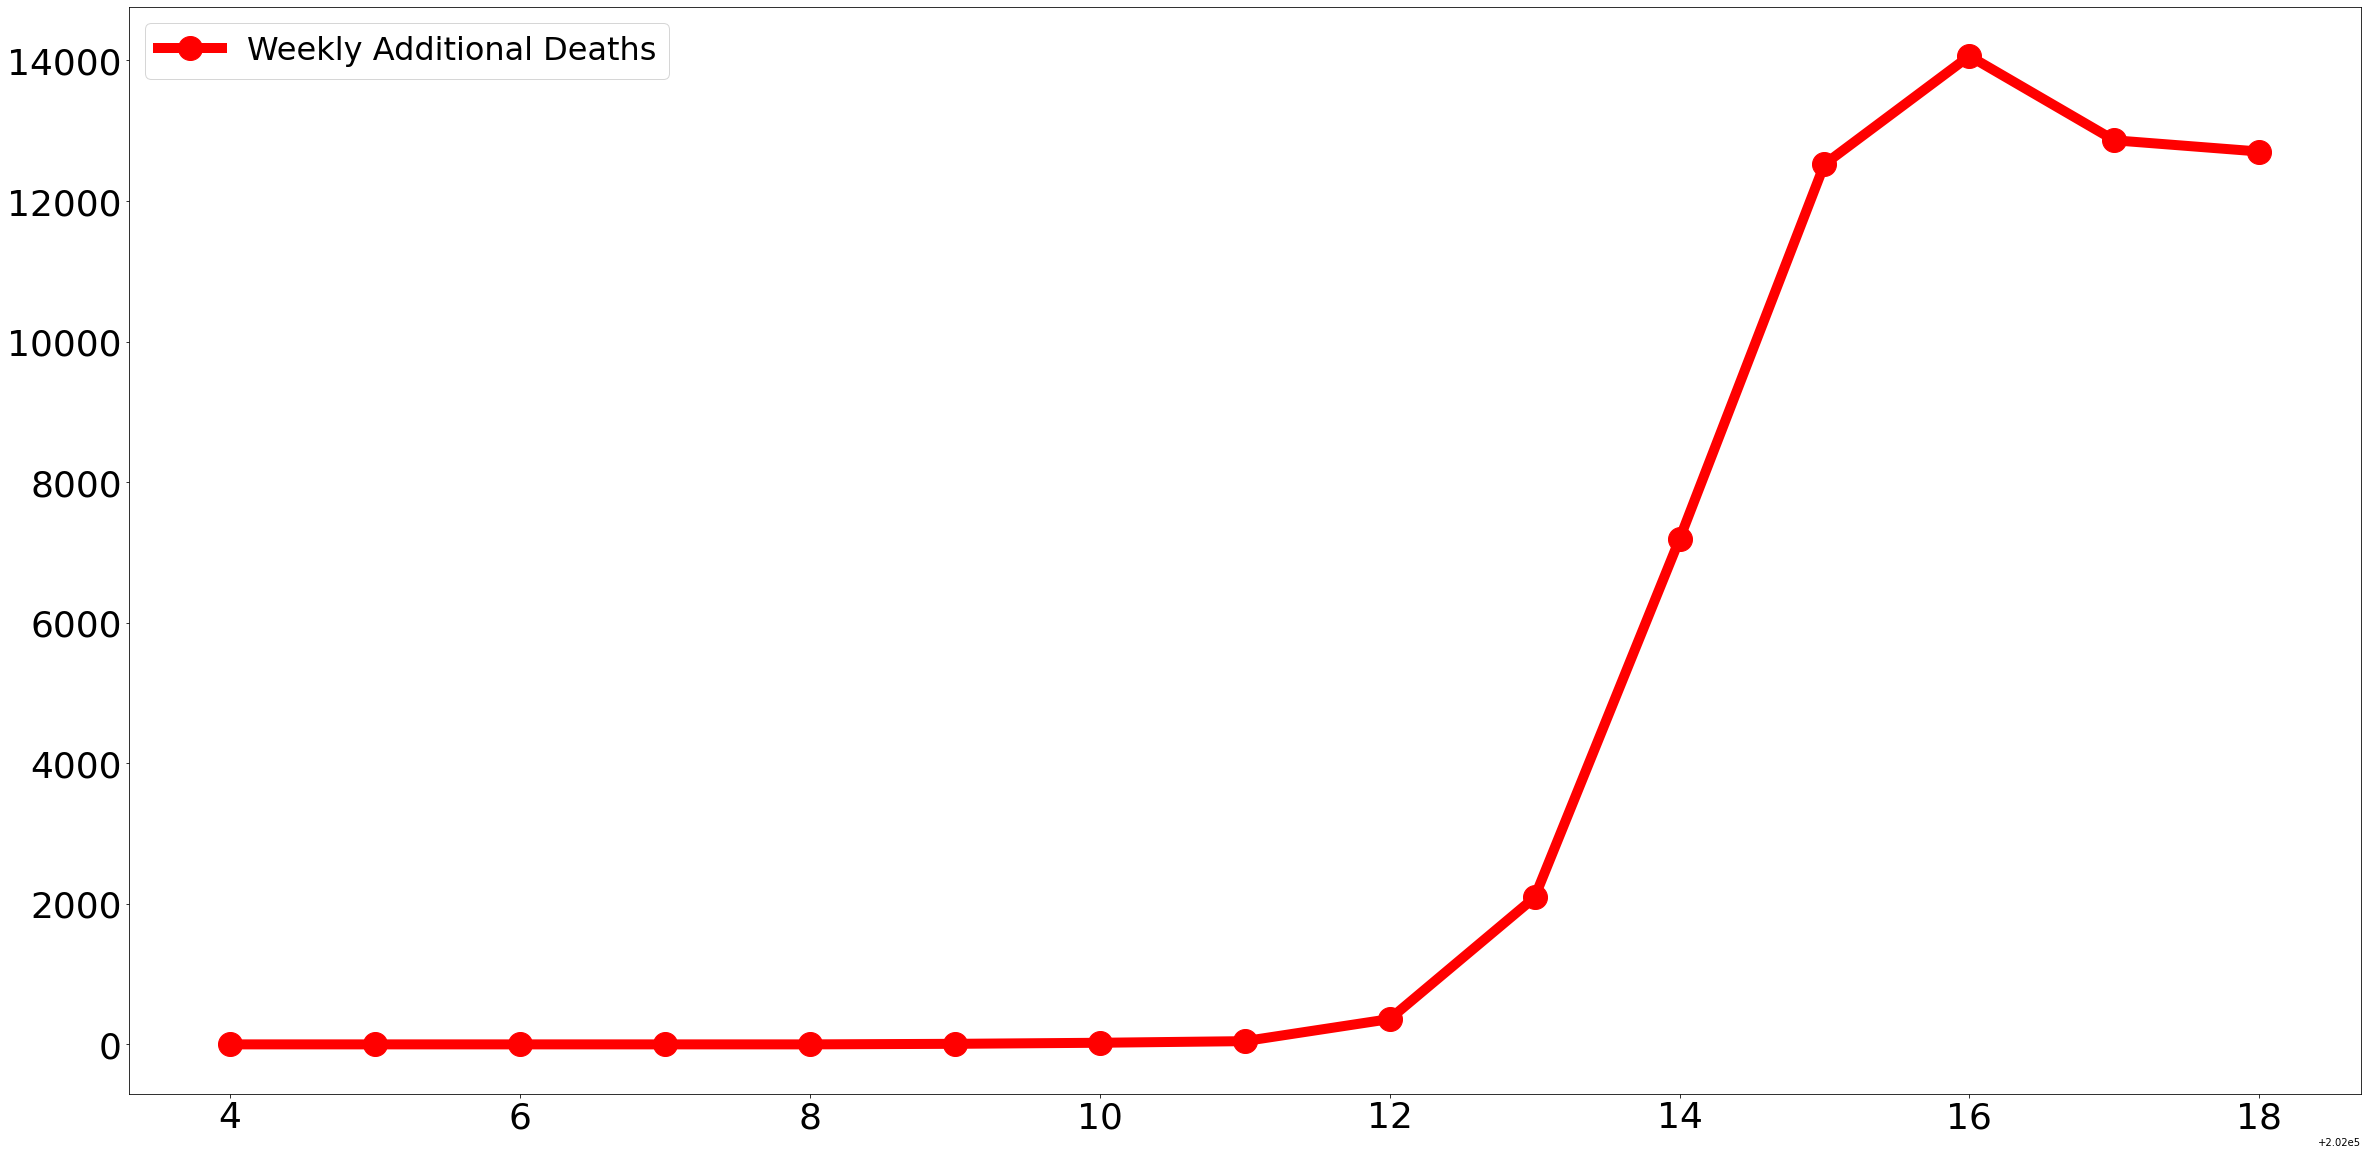

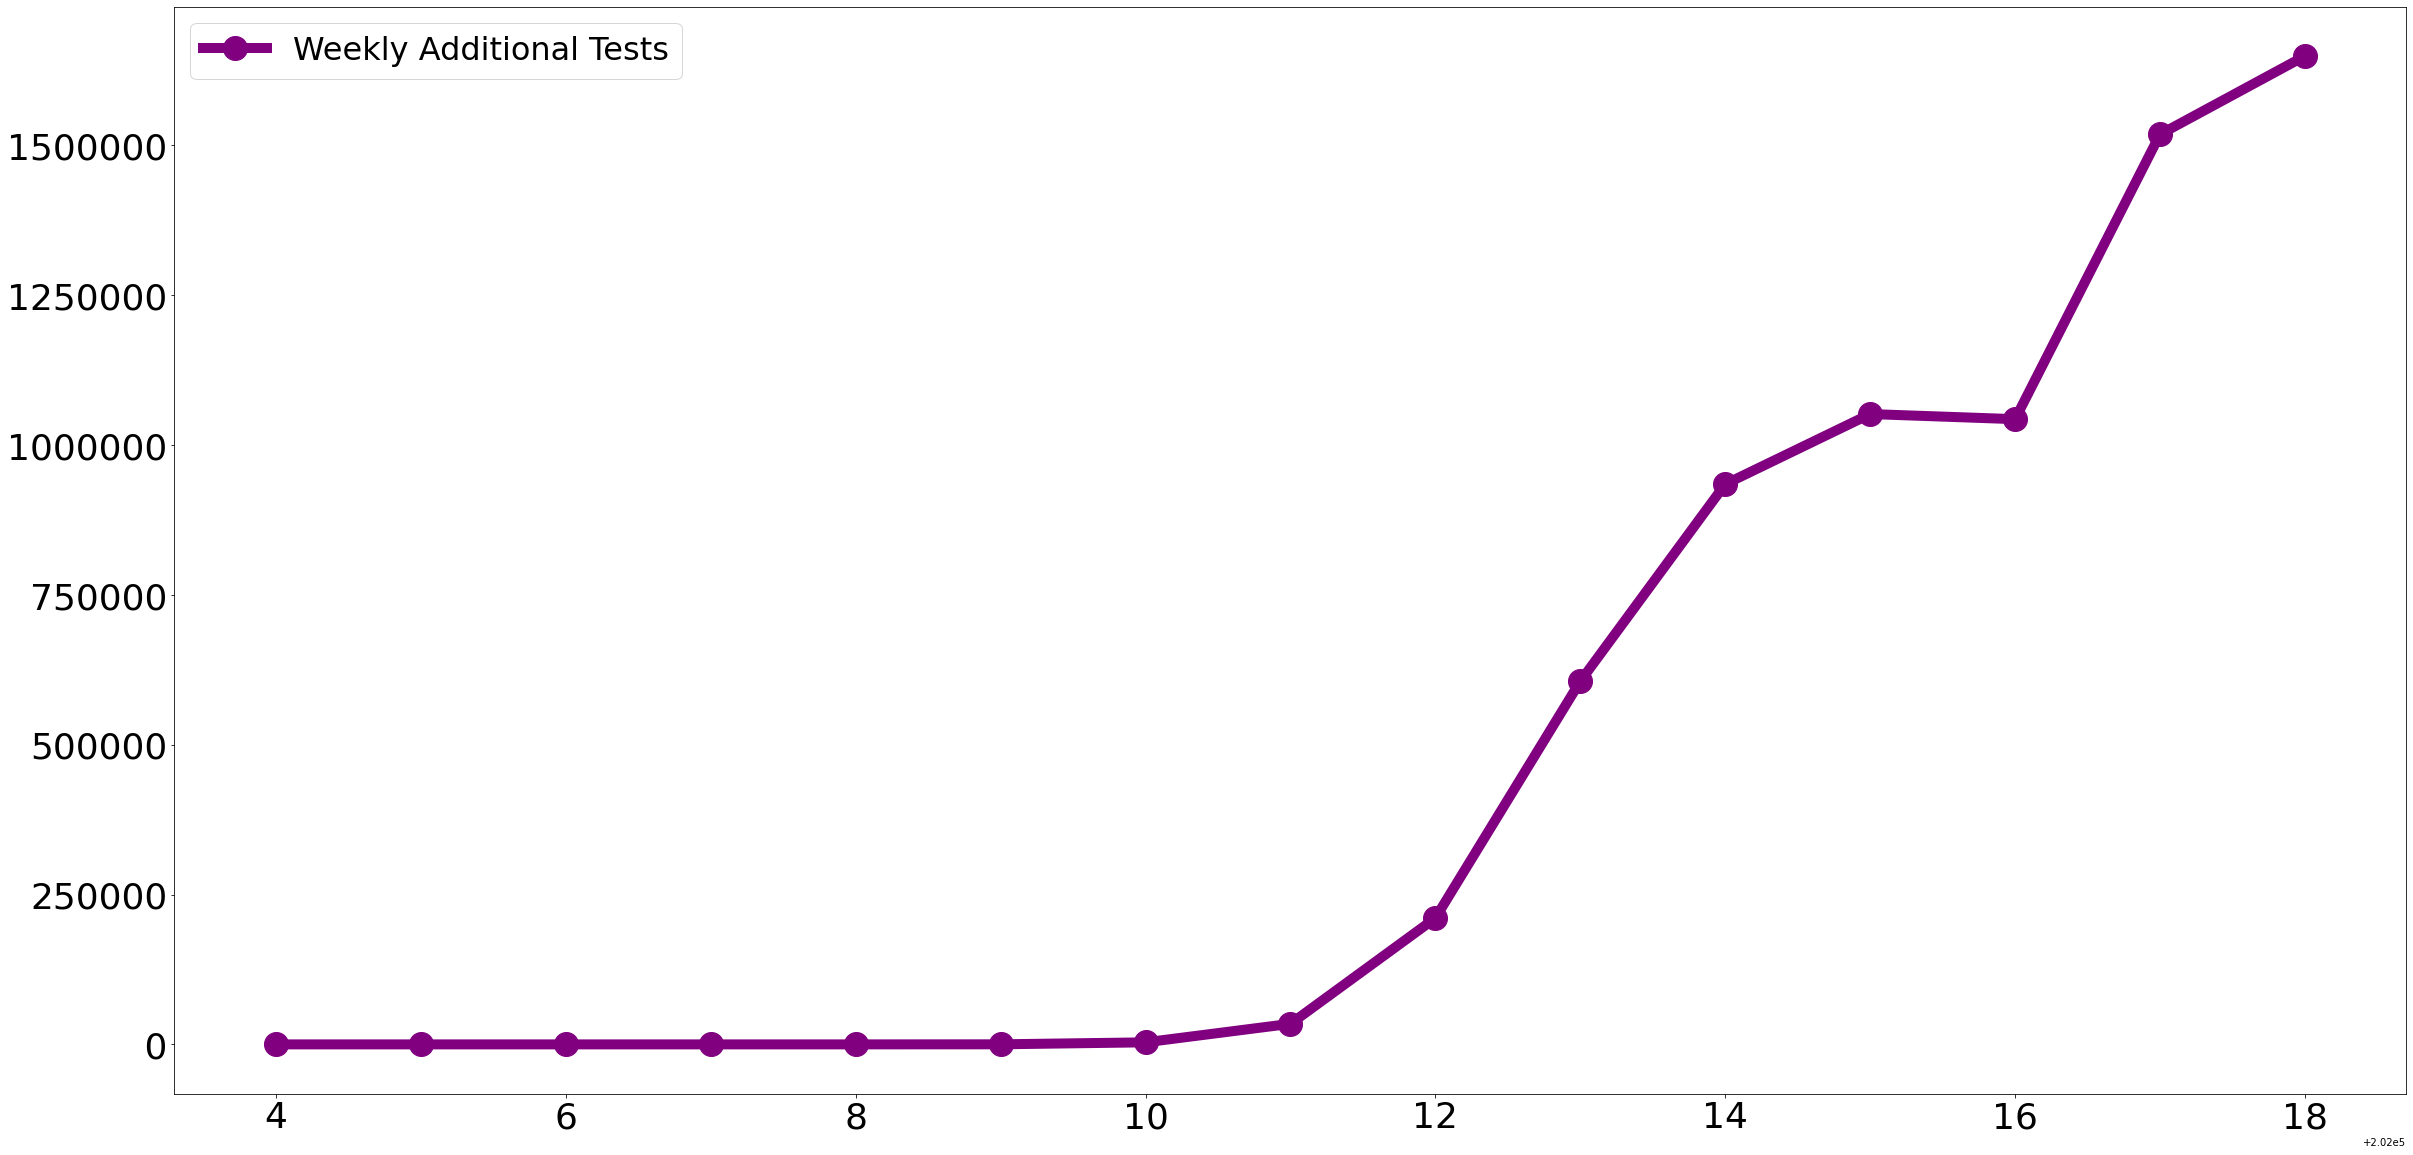

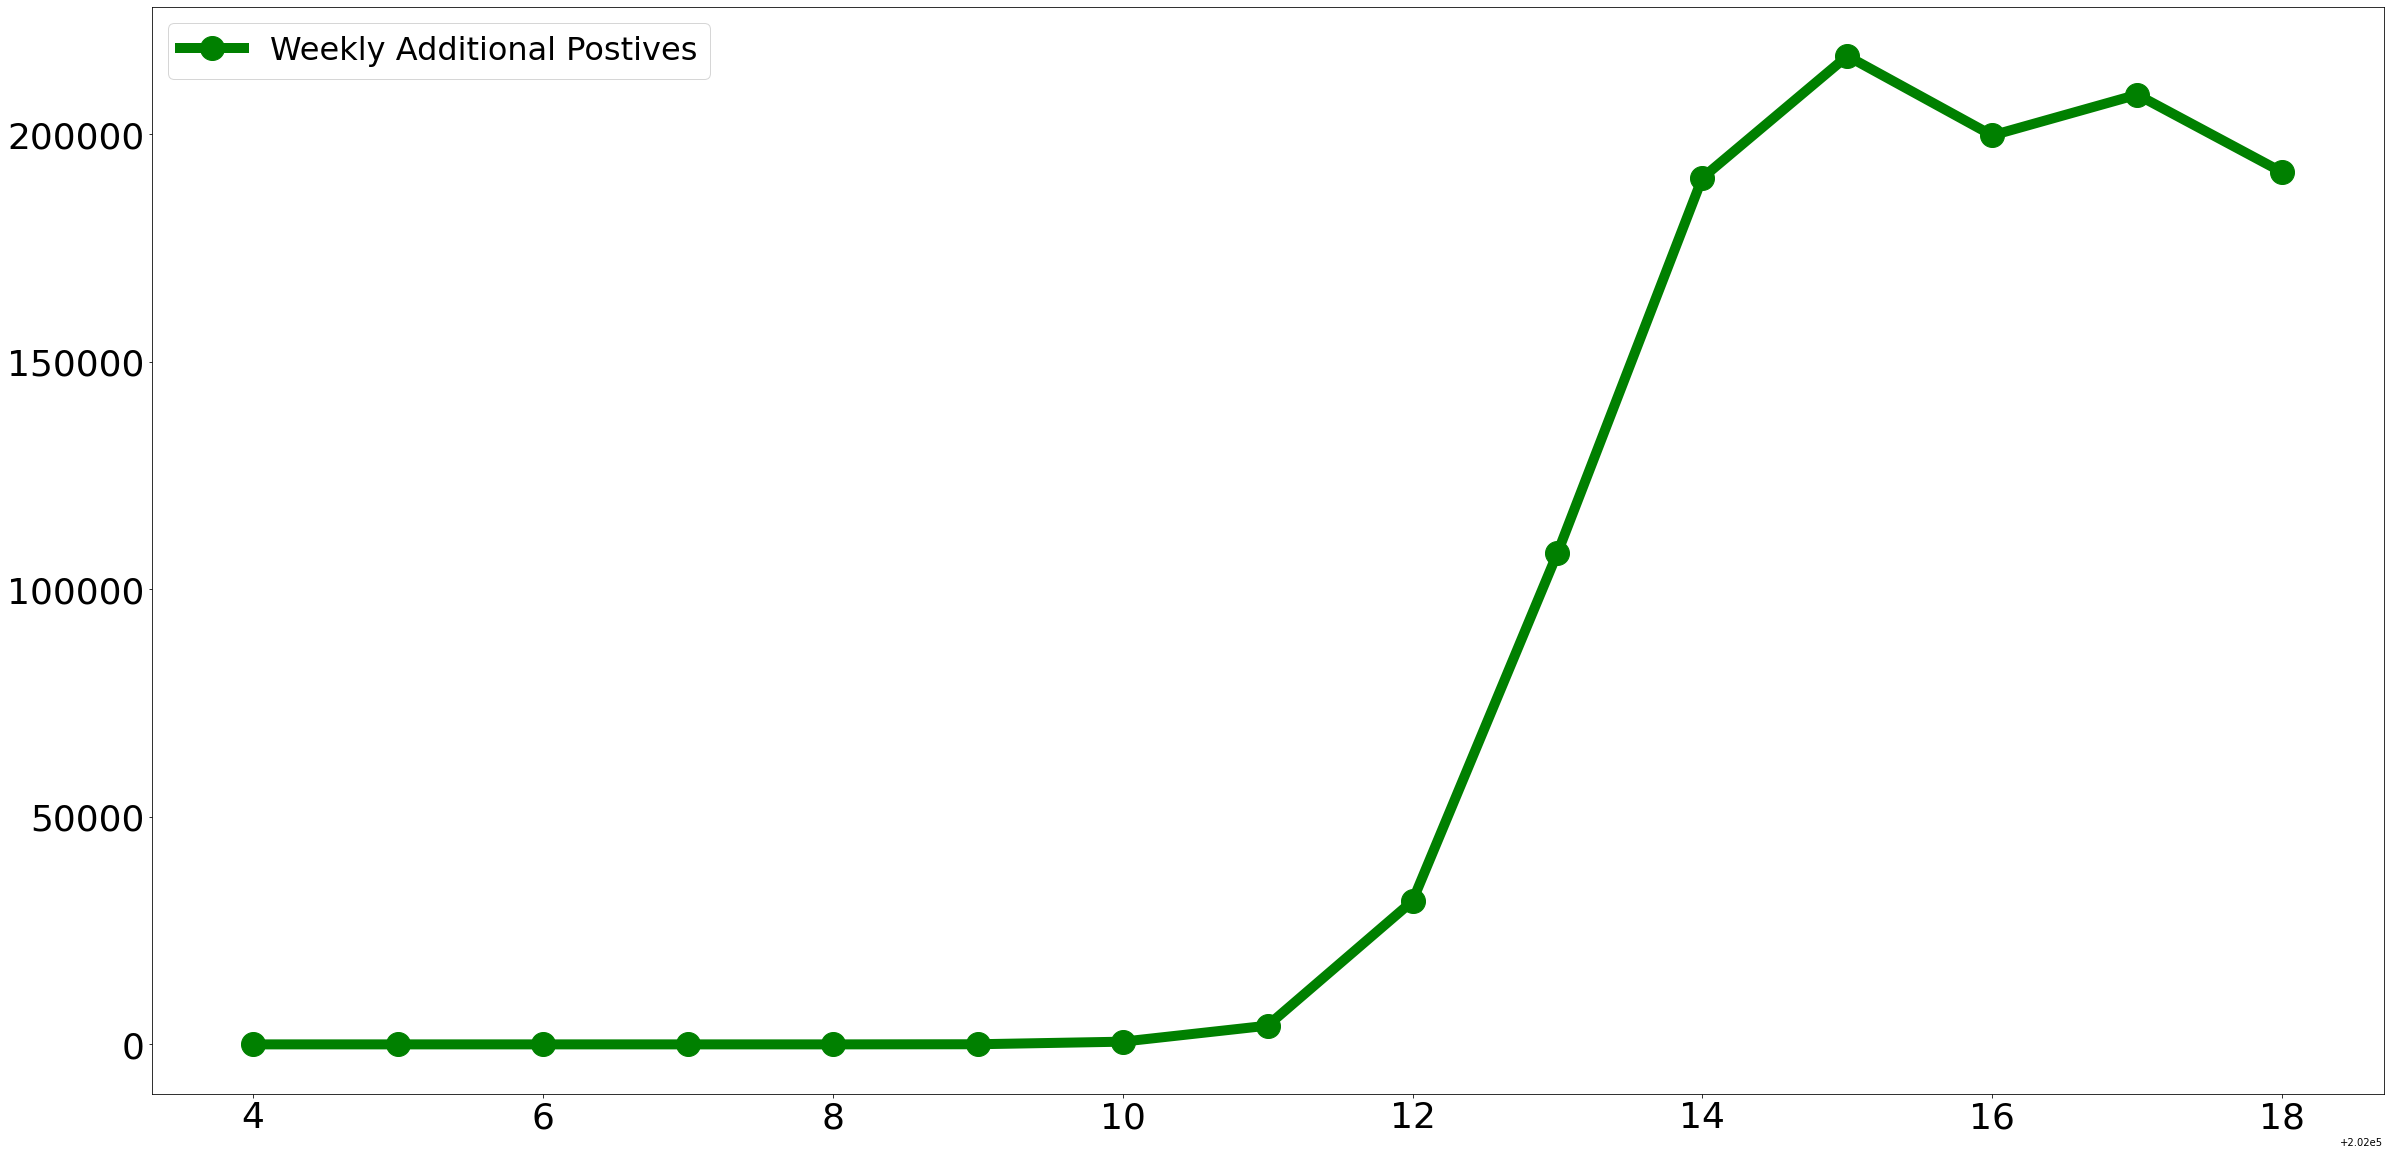

In [36]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

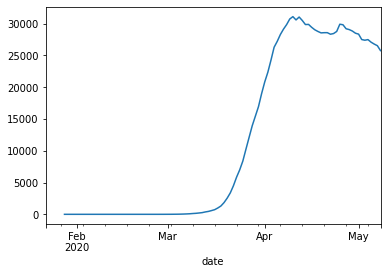

In [37]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

In [39]:
dfCAAvg.index

DatetimeIndex(['2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
               '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
      

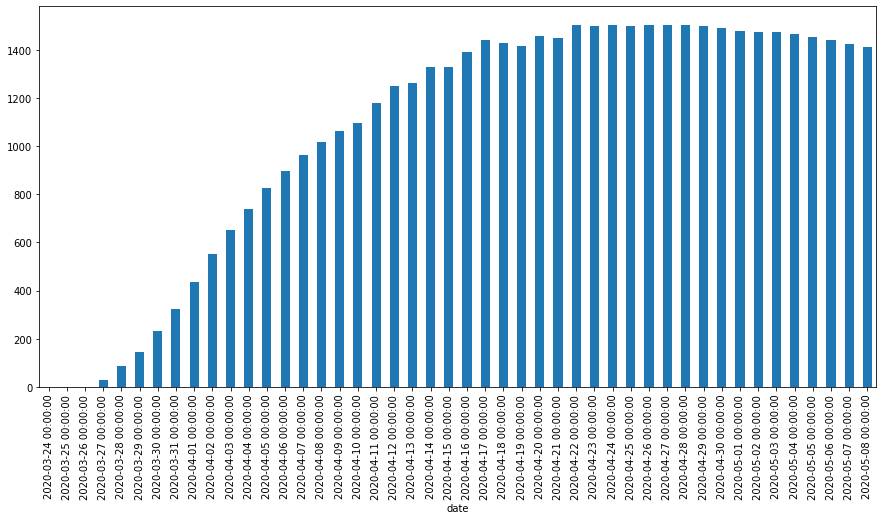

In [40]:

fig, ax = plt.subplots(figsize=(15,7))
graph1 = dfCAAvg[20:].inIcuCurrently.plot(kind='bar',ax=ax)


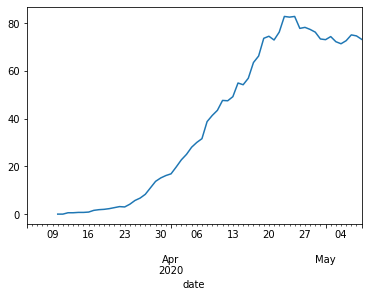

In [41]:
dfCAAvg.deathIncrease.plot.line()

In [42]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
634,FL,2020-05-08,39199,1738,39199,1.000000
635,FL,2020-05-07,38828,1667,39199,0.990535
636,FL,2020-05-06,38002,1605,39199,0.969464
637,FL,2020-05-05,37439,1536,39199,0.955101
638,FL,2020-05-04,36897,1423,39199,0.941274
639,FL,2020-05-03,36078,1403,39199,0.920381
640,FL,2020-05-02,35463,1388,39199,0.904691
641,FL,2020-05-01,34728,1314,39199,0.885941
642,FL,2020-04-30,33690,1290,39199,0.859461
643,FL,2020-04-29,33193,1240,39199,0.846782


In [43]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=5)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,death,current_total,pct
1591,MN,2020-05-03,6663,419,10088,0.660488


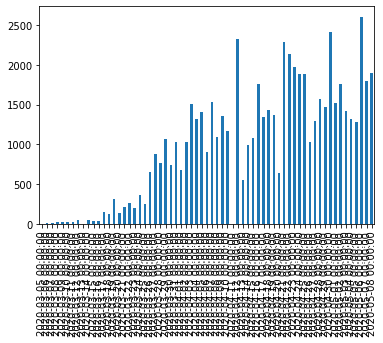

In [44]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [47]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive    1275916
negative    7132872
pending        3307
death         71762
total       8412095
dtype: int64
Current Infection Rate 15.167637%
Percentage of US affected: 0.410578%
Observed CFR: 5.624351%
Percentage of US tested/affected: 2.583647%
Projected affected by cir = 49,786,179
Projected killed = 2,800,150


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [55]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.698440,5.765232
NJ,1.525007,3.363574
MA,1.092970,5.310451
RI,1.017500,8.048814
CT,0.909071,3.380962
DC,0.835850,3.842017
LA,0.663721,4.354162
DE,0.627565,2.902551
IL,0.582079,3.154353


In [56]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 2.561784%


In [57]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [59]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15965 entries, 0 to 15964
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  15771 non-null  object 
 1   location                  15965 non-null  object 
 2   date                      15965 non-null  object 
 3   total_cases               15965 non-null  int64  
 4   new_cases                 15965 non-null  int64  
 5   total_deaths              15965 non-null  int64  
 6   new_deaths                15965 non-null  int64  
 7   total_cases_per_million   15664 non-null  float64
 8   new_cases_per_million     15664 non-null  float64
 9   total_deaths_per_million  15664 non-null  float64
 10  new_deaths_per_million    15664 non-null  float64
 11  total_tests               4061 non-null   float64
 12  new_tests                 3638 non-null   float64
 13  total_tests_per_thousand  4061 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [62]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    8105513.0
RUS    4987468.0
DEU    2755770.0
ITA    2381288.0
IND    1437788.0
         ...    
PRY      13096.0
CRI      10375.0
MMR      10227.0
BOL       8167.0
ZWE       7808.0
Name: total_tests, Length: 84, dtype: float64

In [63]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 29632260
Total tests done in USA : 8105513
How many more times has the world tested more than the US: 3.7


In [64]:
dfOwidLatest[isUSA].sum()

location                                                  United States
date                                                         2020-05-07
total_cases                                                     1228603
new_cases                                                         24128
total_deaths                                                      73431
new_deaths                                                         2353
total_cases_per_million                                         3711.76
new_cases_per_million                                            72.894
total_deaths_per_million                                        221.844
new_deaths_per_million                                            7.109
total_tests                                                 8.10551e+06
new_tests                                                        318720
total_tests_per_thousand                                         24.488
new_tests_per_thousand                                          

In [65]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']
dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-14:]

,new_cases,new_deaths
date,,
2020-04-25,21352,1054
2020-04-26,48529,2172
2020-04-27,26857,1687
2020-04-28,22541,1369
2020-04-29,24132,2110
2020-04-30,27326,2611
2020-05-01,29917,2040
2020-05-02,33955,2062
2020-05-03,29288,1317


In [66]:
dfOwidUSA.set_index('date')

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
date,,,,,,,,,,,,,,,
2019-12-31,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-01,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-02,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-03,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
2020-01-04,USA,United States,0,0,0,0,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,USA,United States,1158041,24972,67682,1297,3498.585,75.444,204.476,3.918,7285374.0,232008.0,22.010,0.701,inconsistent units (COVID Tracking Project)
2020-05-05,USA,United States,1180634,22593,68934,1252,3566.842,68.256,208.258,3.782,7544328.0,258954.0,22.792,0.782,inconsistent units (COVID Tracking Project)
2020-05-06,USA,United States,1204475,23841,71078,2144,3638.868,72.027,214.735,6.477,7786793.0,242465.0,23.525,0.733,inconsistent units (COVID Tracking Project)


In [67]:
dfCovidtracking.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-08,AK,377,25096,0,16.0,0.0,0.0,0.0,0.0,0.0,305.0,C,5/8/2020 00:00,81130d86c029e28f831d55def58fcadc319009c7,2020-05-08T20:00:00Z,10,0.0,25473,25473,25473,02,0.0,0.0,1129.0,3.0,1132.0
1,2020-05-08,AL,9221,110893,0,0.0,1207.0,0.0,454.0,0.0,266.0,0.0,B,5/8/2020 00:00,7aa497df30566f92a1e2edef1fc0ea0aa8bb2120,2020-05-08T20:00:00Z,375,1207.0,120114,120114,120114,01,26.0,29.0,4618.0,323.0,4941.0
2,2020-05-08,AR,3694,60300,0,70.0,466.0,0.0,0.0,14.0,93.0,2159.0,B,5/8/2020 08:15,a4ca6c4d1efac4b48f7e80e29bbc2be13f132133,2020-05-08T20:00:00Z,88,466.0,63994,63994,63994,05,1.0,4.0,3916.0,83.0,3999.0
3,2020-05-08,AS,0,83,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,5/3/2020 00:00,aee242eef36c48dcf1bf337be214b3af34e8e755,2020-05-08T20:00:00Z,0,0.0,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,2020-05-08,AZ,10526,109381,0,730.0,1482.0,295.0,0.0,197.0,0.0,1747.0,A+,5/8/2020 00:00,f90cd0eb502865124ca024e8cd4dd3173109c8a9,2020-05-08T20:00:00Z,517,1482.0,119907,119907,119907,04,67.0,33.0,8240.0,581.0,8821.0


In [0]:
dfWeeklyFL = dfCovidtracking.loc[dfCovidtracking.state=='FL'].set_index('date')\
.groupby(by=lambda x: x.week).sum()


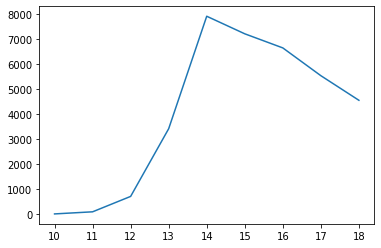

In [69]:
plt = dfWeeklyFL[:-1].positiveIncrease.plot.line()

In [70]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

38828

In [71]:
dfCovidtracking[dfCovidtracking.state=='FL']

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
10,2020-05-08,FL,39199,474142,1433,0.0,7157.0,0.0,0.0,0.0,0.0,0.0,C,5/8/2020 10:10,d523f47e828d33beb300781280737503c7ddcbb1,2020-05-08T20:00:00Z,1738,7157.0,514774,513341,513341,12,71.0,167.0,20020.0,371.0,20391.0
66,2020-05-07,FL,38828,454122,1499,0.0,6990.0,0.0,0.0,0.0,0.0,0.0,C,5/7/2020 14:40,82a555f5e7054b394251d1718a523e26517abba0,2020-05-07T20:00:00Z,1667,6990.0,494449,492950,492950,12,62.0,214.0,12073.0,826.0,12899.0
122,2020-05-06,FL,38002,442049,1351,0.0,6776.0,0.0,0.0,0.0,0.0,0.0,C,5/6/2020 09:45,ef53ede20479581dcab76508f0c672a9542fe387,2020-05-06T20:00:00Z,1605,6776.0,481402,480051,480051,12,69.0,230.0,13797.0,563.0,14360.0
178,2020-05-05,FL,37439,428252,1265,0.0,6546.0,0.0,0.0,0.0,0.0,0.0,C,5/5/2020 10:31,cc9858355edd3f9217a9161416e34034e40cfd24,2020-05-05T20:00:00Z,1536,6546.0,466956,465691,465691,12,113.0,217.0,20879.0,542.0,21421.0
234,2020-05-04,FL,36897,407373,1181,0.0,6329.0,0.0,0.0,0.0,0.0,0.0,C,5/4/2020 09:12,ab9900a3978e419e37fd28c4c86ff5943dbb92e4,2020-05-04T20:00:00Z,1423,6329.0,445451,444270,444270,12,20.0,85.0,15262.0,819.0,16081.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,2020-03-08,FL,17,118,108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6fe85d0dc53d6860063f38e98dccf29e36f035c3,2020-03-08T20:00:00Z,0,0.0,243,135,135,12,0.0,0.0,18.0,3.0,21.0
3437,2020-03-07,FL,14,100,88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,78b1ecd25b46274b2fb969cd705c9ce078f24642,2020-03-07T21:00:00Z,0,0.0,202,114,114,12,0.0,0.0,45.0,5.0,50.0
3485,2020-03-06,FL,9,55,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6b75ea058687eb6f8643e53e3f75f8739b986534,2020-03-06T21:00:00Z,0,0.0,115,64,64,12,0.0,0.0,24.0,0.0,24.0
3518,2020-03-05,FL,9,31,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,be40a4f79a747d11e86a789e72624d9fb7e87651,2020-03-05T21:00:00Z,0,0.0,109,40,40,12,0.0,0.0,7.0,7.0,14.0


In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'].set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [73]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,208.0,715.0,20005.0,3811.0,23816.0
1,355.0,1218.0,39541.0,5795.0,45336.0
2,247.0,1438.0,21047.0,5634.0,26681.0
3,181.0,815.0,32586.0,4532.0,37118.0
4,236.0,968.0,42359.0,5962.0,48321.0
5,90.0,579.0,25740.0,3544.0,29284.0
6,60.0,202.0,14183.0,2826.0,17009.0
